# Sentiment Analysis using NLP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,KFold
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, recall_score, precision_score,classification_report,roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn import svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle

import xgboost as xgb

import nltk
from nltk.corpus import stopwords, wordnet
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

from wordcloud import WordCloud
from joblib import dump, load
import pickle
import string
import re
import time
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importing the dataset
data = pd.read_csv("training_data.csv")
data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


## Data Exploration

In [4]:
# Renaming Column Names
data.columns = ["sentiment", "time", "date", "query", "username", "text"]
data.head()

,sentiment,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [5]:
data.shape

(1599999, 6)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1599999 non-null  int64 
 1   time       1599999 non-null  int64 
 2   date       1599999 non-null  object
 3   query      1599999 non-null  object
 4   username   1599999 non-null  object
 5   text       1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
# Checking for null values
data.isnull().sum()

sentiment    0
time         0
date         0
query        0
username     0
text         0
dtype: int64

Since there are no null values within the dataset, we can proceed with the process.

In [8]:
# Checking the unique values in the target variable
data['sentiment'].value_counts()

4    800000
0    799999
Name: sentiment, dtype: int64

<AxesSubplot:>

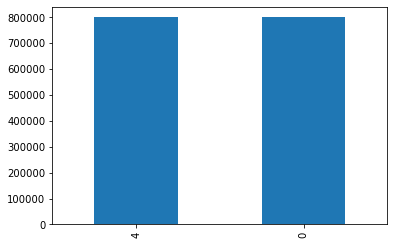

In [9]:
# Bar Chart Illustrating Unique Values 
data['sentiment'].value_counts().plot.bar()

## Data Preparation

In [10]:
data.head()

,sentiment,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [11]:
# Extracting only text & sentiment
data = data[['text','sentiment']]
data.head()

,text,sentiment
0,is upset that he can't update his Facebook by ...,0
1,@Kenichan I dived many times for the ball. Man...,0
2,my whole body feels itchy and like its on fire,0
3,"@nationwideclass no, it's not behaving at all....",0
4,@Kwesidei not the whole crew,0


In [12]:
# Checking the unique values in the target variable
data['sentiment'].value_counts()

4    800000
0    799999
Name: sentiment, dtype: int64

In [13]:
# Converting the positive sentiment value from '4' to '1' for better understanding
data['sentiment'] = data['sentiment'].apply(lambda x : 1 if x == 4 else x)

In [14]:
# Checking the unique values in the target variable
data['sentiment'].value_counts()

1    800000
0    799999
Name: sentiment, dtype: int64

In [15]:
data.head()

,text,sentiment
0,is upset that he can't update his Facebook by ...,0
1,@Kenichan I dived many times for the ball. Man...,0
2,my whole body feels itchy and like its on fire,0
3,"@nationwideclass no, it's not behaving at all....",0
4,@Kwesidei not the whole crew,0


In [16]:
# Converting text and sentiment columns to lists
text, sentiment = list(data['text']), list(data['sentiment'])

## Data Preprocessing

**Text Preprocessing** is an essential step in **Natural Language Processing (NLP)** as it transforms the text into a more apprehendable form in order for machine learning algorithms to perform better.

**The Preprocessing steps taken:**
1. **Lower Casing:** Text is converted to lowercase.
2. **Replacing URLs:** Links are replaced by "URL".
3. **Replacing Emojis:** Emojis are replaced by with pre-defined dictionary consisting of emojis with their meanings. *(eg: ":)" to "EMOJIsmile")*
4. **Replacing Usernames:** Replace @Usernames with word "USER". *(eg: "@Kaggle" to "USER")*
5. **Removing Non-Alphabets:** Replacing non-alphabetic characters with a space.
6. **Removing Consecutive letters:** Words consisting of 3 or more repeated letters are replaced by 2 letters. *(eg: "Heyyyy" to "Heyy")*
7. **Removing Short Words:** Words with less than 2 letters are removed.
8. **Removing Stopwords:** Stopwords are words that don't add significant meaning to a sentence. These could be ignored without changing the meaning of the sentence. *(eg: "the", "has", "have")*
9. **Lemmatizing:** Lemmatization is the process of converting a word to its base form. *(e.g: “Great” to “Good”)*

In [17]:
# Defining a method to perform preprocessing

def preprocess(text):
    
    # Dictionary consisting of emojis with meanings
    
    emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
              ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
              '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
              ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
              ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat', 
              ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
              '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink'}

    stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
                 'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
                 'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
                 'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
                 'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
                 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
                 'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
                 'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
                 'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
                 's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
                 't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
                 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
                 'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
                 'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
                 'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
                 "youve", 'your', 'yours', 'yourself', 'yourselves']


    processed_text = []
        
    # Defining Regex Patterns
    url_pattern         = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    user_pattern        = '@[^\s]+'
    alpha_pattern       = "[^a-zA-Z]"
    sequence_pattern    = r"(.)\1\1+"
    seq_replace_pattern = r"\1\1"
    
    for tweet in text:
        
        # Converting text to lowercase
        tweet = tweet.lower()
        
        # Replacing URLs with 'URL'
        tweet = re.sub(url_pattern, ' URL', tweet)
        
        # Replacing emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, 'EMOJI' + emojis[emoji])    
            
        # Replacing usernames with 'USER'.
        tweet = re.sub(user_pattern, ' USER', tweet)  
        
        # Replacing non-alphabetic charcters.
        tweet = re.sub(alpha_pattern, " ", tweet)
        
        # Replacing 3 or more Consecutive Letters with 2 Letters.
        tweet = re.sub(sequence_pattern, seq_replace_pattern, tweet)
        
        all_char = []
        
        # Removing Punctuations if required
        all_char = [char for char in tweet if char not in string.punctuation]
        tweet = ''.join(all_char)
        
        # Removing Stopwords
        tweet_words = ''
        for word in tweet.split():
            if word not in (stopwordlist):
                if len(word)>1:
                    tweet_words += (word+' ')
            
        processed_text.append(tweet_words)
        
    return processed_text

In [18]:
preprocessed_text = preprocess(text)

In [19]:
# Method to return the 2nd parameter for Lemmatization (POS Tag)
def get_wordnet_pos_tag(tag):
    
    if tag.startswith("J"):
        return wordnet.ADJ
    
    if tag.startswith("V"):
        return wordnet.VERB
    
    if tag.startswith("N"):
        return wordnet.NOUN
    
    if tag.startswith("R"):
        return wordnet.ADV
    
    else:
        return wordnet.NOUN

In [20]:
# Method to perform Lemmatization with POS Tags
def lemmatize(preprocessed_text):
    
    # Creating Lemmatizer
    lemma = WordNetLemmatizer()
    final_text = []
    
    for tweet in preprocessed_text:
        text_pos = pos_tag(word_tokenize(tweet))
        words = [x[0] for x in text_pos]
        pos = [x[1] for x in text_pos]
        tweet_lemma = " ".join([lemma.lemmatize(a, get_wordnet_pos_tag(b)) for a,b in zip(words, pos)])
        final_text.append(tweet_lemma)
    return final_text

In [21]:
processed_text = lemmatize(preprocessed_text)

## Data Analysis

### Positive Words

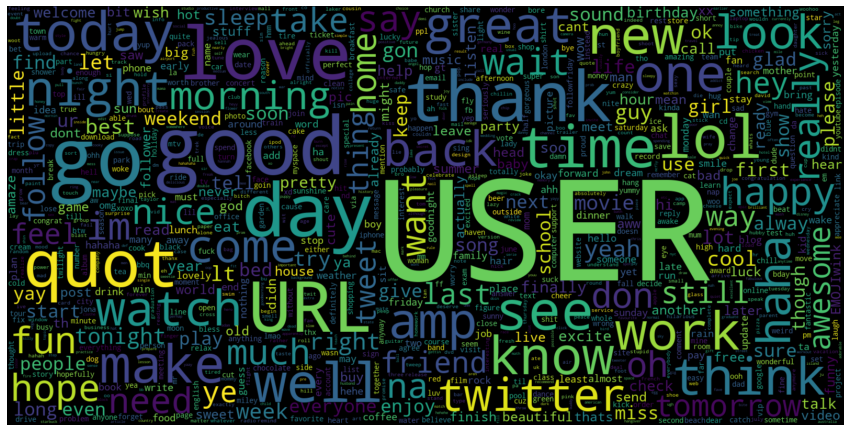

In [22]:
# Generating Wordcloud with Positive Tweets

positive_words = processed_text[800000:]
all_positive_words = ' '.join(positive_words)

pos_wordcloud = WordCloud(max_words = 1000, width= 1600, height= 800,
                      collocations = False).generate(all_positive_words)
plt.figure(figsize=(15,10))
plt.imshow(pos_wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

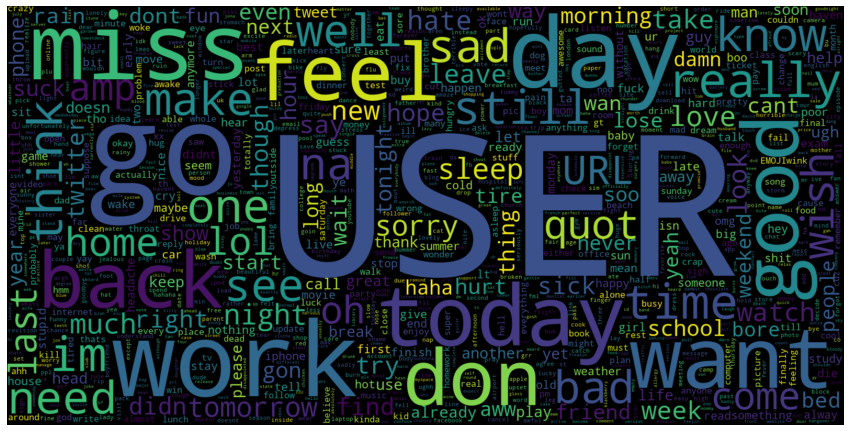

In [23]:
# Generating Wordcloud with Negative Tweets

negative_words = processed_text[:800000]
all_negative_words = ' '.join(negative_words)

neg_wordcloud = WordCloud(max_words = 1000, width= 1600, height= 800,
                      collocations = False).generate(all_negative_words)
plt.figure(figsize=(15,10))
plt.imshow(neg_wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

In [24]:
# Identifying the most frequent set of words in the dataset

token_wspace = tokenize.WhitespaceTokenizer()

def most_frequent_words(tweets, quantity):
    all_words = ' '.join(tweets)
    all_tokens = token_wspace.tokenize(all_words)
    freq_dist = nltk.FreqDist(all_tokens)
    df_frequency = pd.DataFrame({"Word":list(freq_dist.keys()), "Frequency":list(freq_dist.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'deepskyblue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

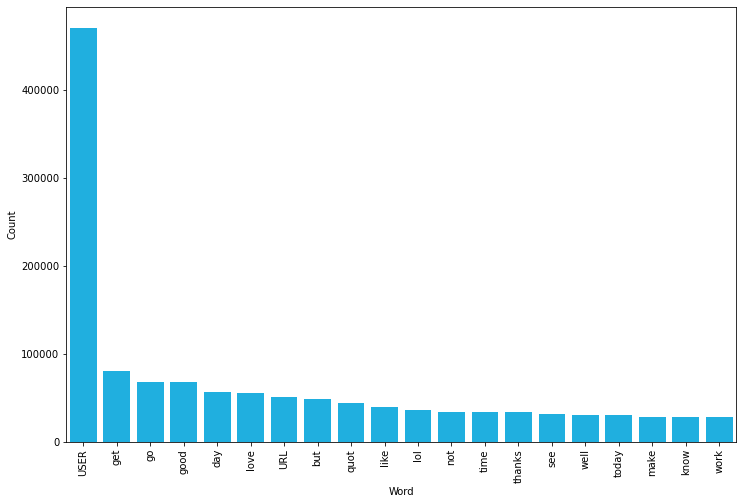

In [25]:
# Plotting the top 10 most frequent words in Positive Tweets
most_frequent_words(processed_text[800000:], 20)

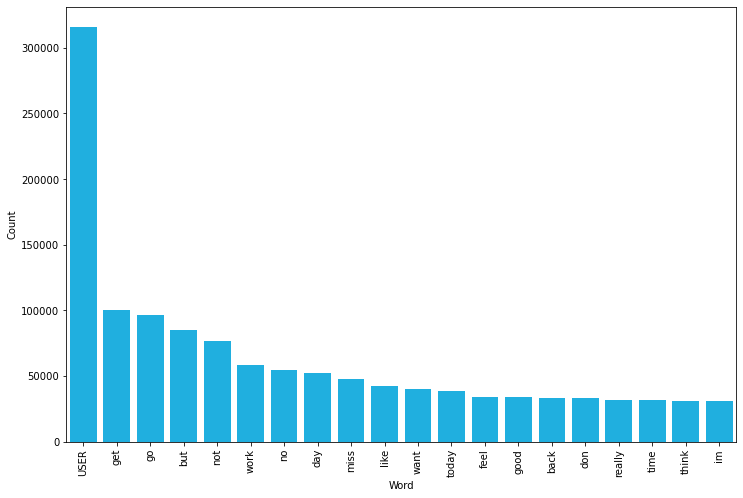

In [26]:
# Plotting the top 10 most frequent words in Negative Tweets
most_frequent_words(processed_text[:800000], 20)

### Splitting into Train & Test Data

In [27]:
# Splitting the dataset into Train and Test Data
X_train, X_test, y_train, y_test = train_test_split(processed_text, sentiment,
                                                    test_size = 0.10, random_state = 0)

## TF-IDF Vectorizer

TF-IDF allows us to identify the **importance** of a word within the context/dataset based on its **Frequency**.

**TF-IDF Vectorizer** converts a collection of raw documents to a **matrix of TF-IDF features**.

**ngram_range**  is the range of the number of words within a sequence.

**max_features** specifies the number of features to be considered.

In [28]:
# TF-IDF vectorizer on train data 
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [29]:
# Transforming X_train and X_test Data
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

## Developing & Evaluating ML Models

In [30]:
# Method run model on test data and Check Accuracy, Confusion Matrix and ROC Curve

def model_evaluate(model):
    
    # Predict values for Test data
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted Values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual Values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    
    
    plt.title ("ROC Curve")
    
    #Area under Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return y_pred

## LinearSVC Model

              precision    recall  f1-score   support

           0       0.80      0.79      0.79     80048
           1       0.79      0.81      0.80     79952

    accuracy                           0.80    160000
   macro avg       0.80      0.80      0.80    160000
weighted avg       0.80      0.80      0.80    160000



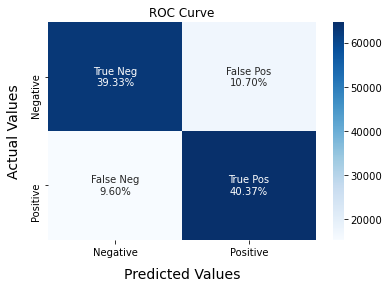

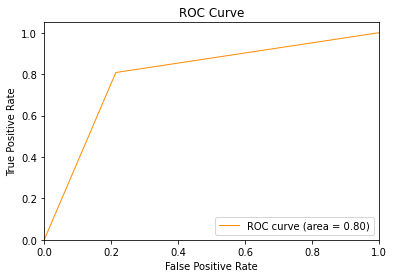

array([1, 1, 0, ..., 0, 1, 0])

In [31]:
# Creating and evaluating a Linear SVC model

SVC_model = LinearSVC()
SVC_model.fit(X_train, y_train)
model_evaluate(SVC_model)

## BernoulliNB Model

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     80048
           1       0.79      0.80      0.79     79952

    accuracy                           0.79    160000
   macro avg       0.79      0.79      0.79    160000
weighted avg       0.79      0.79      0.79    160000



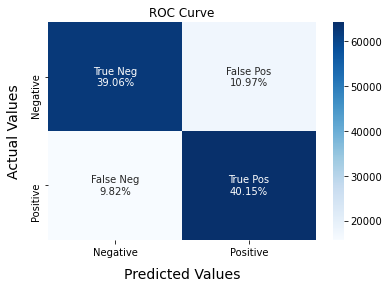

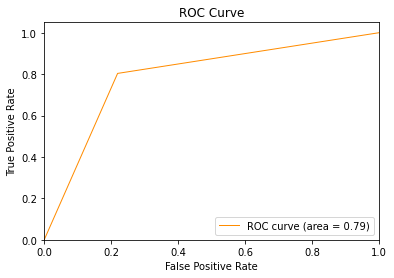

array([1, 1, 0, ..., 1, 1, 0])

In [32]:
# Creating and evaluating a Bernoulli Naive Bayes model
BNB_model = BernoulliNB(alpha = 2)
BNB_model.fit(X_train, y_train)
model_evaluate(BNB_model)

## Logistic Regression Model

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     80048
           1       0.80      0.82      0.81     79952

    accuracy                           0.81    160000
   macro avg       0.81      0.81      0.81    160000
weighted avg       0.81      0.81      0.81    160000



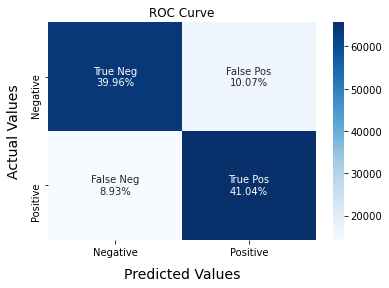

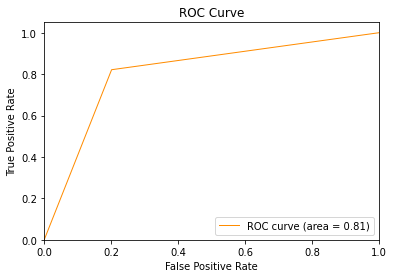

In [33]:
# Created a Logistic Regression model with regularization parameter and max iteration limit and then evaluating the model
LR_model = LogisticRegression(C = 1, max_iter = 1000, n_jobs=-1)
LR_model.fit(X_train, y_train)
y_test_pred = model_evaluate(LR_model)

Upon developing the 3 ML Models above, we can identify that **The Logistic Regression Model** outperforms the others in terms of accuracy. This can be concluded as the model identifies the sentiment of the tweets within the dataset with an accuracy of 81%. Hence, this would be the ideal model for the system being generated.

It should also be noted that **The BernoulliNB Model** performed the fastest during training and evaluation. This model had an accuracy of 79% which indicates a slightly more inaccurate prediction in comparison to the other models.

In [34]:
# Identifying the Positive and Negative Sentiments based on Logistic Regression Model
print("Positive Sentiment Percentage : {}%".format(round(np.count_nonzero(y_test_pred == 1) / len(y_test_pred) * 100, 2)))
print("Negative Sentiment Percentage : {}%".format(round(np.count_nonzero(y_test_pred == 0) / len(y_test_pred) * 100, 2)))

Positive Sentiment Percentage : 51.12%
Negative Sentiment Percentage : 48.88%


## Saving the Model

In [35]:
file = open('D:/tuansihan/06 Projects/01 Machine Learning/07 Sentiment Analysis/vectorizer.pickle', 'wb')
pickle.dump(vectorizer, file)
file.close()

file = open('D:/tuansihan/06 Projects/01 Machine Learning/07 Sentiment Analysis/Sentiment-LR.pickle', 'wb')
pickle.dump(LR_model, file)
file.close()

## Implementing the Model

In order to test the accuracy of the model, for we would need to import the Vectorizer and LR Model using Pickle.

The vectorizer would be used to transform the data into a matrix of TF-IDF Features.
While the model could be used to predict the sentiment of the transformed Data.
The text whose sentiment is being predicted would have to be preprocessed.

In [64]:
# Method to load models from pickle file
def loading_models():  
       
    # Load the vectorizer.
    file = open('D:/tuansihan/06 Projects/01 Machine Learning/07 Sentiment Analysis/vectorizer.pickle', 'rb')
    vectorizer = pickle.load(file)
    file.close()
    
    # Load the LR Model.
    file = open('D:/tuansihan/06 Projects/01 Machine Learning/07 Sentiment Analysis/Sentiment-LR.pickle', 'rb')
    LR_model = pickle.load(file)
    file.close()
    
    return vectorizer, LR_model

In [61]:
# Method to perform TF-IDF vectorizer on test data
def prediction(vectorizer, model, text):
    final_data = []

    text_data = vectorizer.transform(lemmatize(preprocess(text)))
    sentiment = model.predict(text_data)
    
    sentiment_prob = model.predict_proba(text_data)
    
    for index, tweet in enumerate(text):
        if sentiment[index] == 1:
            sentiment_prob_final = sentiment_prob[index][1]
        else:
            sentiment_prob_final = sentiment_prob[index][0]
            
        sentiment_prob_final_2 = "{}%".format(round(sentiment_prob_final * 100, 2))
        final_data.append((tweet, sentiment[index], sentiment_prob_final_2))
           
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(final_data, columns = ['Tweet','Sentiment', 'Confidence Level'])
    df = df.replace([0,1], ['Negative','Positive'])
    return df

In [66]:
# Creating list with sample tweets to classify
text = ["Sihan loves data",
        "Avengers is the best movie ever",
        "Mr. Stark, I don't feel so good",
        "I hate him!",
        "I just read the book, it was a great read!",
        "I can't wait to see what the team is up to"]

In [67]:
# Testing the model on text list
vectorizer, LR_model = loading_models()

df = prediction(vectorizer, LR_model, text)
df

,tweet,sentiment,Confidence Level
0,Sihan loves data,Positive,81.54%
1,Avengers is the best movie ever,Positive,90.01%
2,"Mr. Stark, I don't feel so good",Negative,69.47%
3,I hate him!,Negative,99.98%
4,"I just read the book, it was a great read!",Positive,91.85%
5,I can't wait to see what the team is up to,Positive,93.76%


As illustrated by the example above, the model seems to predict the sentiments of each phrase/tweet within the list fairly well. We can now further test the model with unseen test data by implementing the following steps:

## Testing the Model on Test Data

By performing the analysis below, we could identify and priotize tweets that could indicate an alarming situation based on the intensity of the tweet itself.

_Eg. Unforeseen Hurricanes or Thunders tweeted by users which are indicated as **Negative Tweets** could be paid immediate attention by authorities when prioritized with a model as the one developed in this project._

In [69]:
test_data = pd.read_csv("test_data.csv")
test_data.head()

,url,date,text
0,https://twitter.com/EcoLisa_/status/9022754290...,Mon Aug 28 21:03:20 2017,Here's how you can help victims of #HurricaneH...
1,https://twitter.com/RedefiningDecor/status/903...,Thu Aug 31 15:43:15 2017,RT @tripgabriel: This is a very gripping graph...
2,https://twitter.com/BestofY00/status/903281998...,Thu Aug 31 15:43:05 2017,RT @tripgabriel: This is a very gripping graph...
3,https://twitter.com/Deborah9111966/status/9032...,Thu Aug 31 15:43:01 2017,RT @tripgabriel: This is a very gripping graph...
4,https://twitter.com/kirkbocchi/status/90328194...,Thu Aug 31 15:42:53 2017,RT @tripgabriel: This is a very gripping graph...


In [70]:
data.shape

(1599999, 2)

In [71]:
# Storing text data from dataset into a list for further processing
text = list(test_data['text'])

In [77]:
# Method to perform TF-IDF vectorizer on test data and predict sentiment

def predict_excel(vectorizer, model, text):
    final_data = []

    text_data = vectorizer.transform(lemmatize(preprocess(text)))
    sentiment = model.predict(text_data)
    
    sentiment_prob = model.predict_proba(text_data)
    
    for index, tweet in enumerate(text):
        sentiment_prob_final = sentiment_prob[index][0]
            
        sentiment_prob_final_2 = "{}%".format(round(sentiment_prob_final * 100,2))
        final_data.append((tweet, sentiment[index], sentiment_prob_final_2))
           
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(final_data, columns = ['Tweet', 'Sentiment', 'Intensity'])
    df = df.replace([0,1], ['Negative', 'Positive'])
    
    return df

In [79]:
vectorizer, LR_model = loading_models()
df = predict_excel(vectorizer, LR_model, text)

In [80]:
# Sorting Values based on Intensity
df.sort_values(by = ['Intensity'], ascending = False, inplace = True)
df

,Tweet,Sentiment,Intensity
6888,When the storm comes it affects us all...no ex...,Negative,99.56%
2009,This breaks my heart. I wish I could do more t...,Negative,99.54%
18,This is so sad. Thousands Cried for Help as Ho...,Negative,99.37%
9121,It's Sad That Some Hispanics In Houston Have T...,Negative,99.22%
9794,Sad and scary situation in Houston https://t.c...,Negative,99.08%
...,...,...,...
9581,RT @PRyan: Thank you @JJWatt. You make Wiscons...,Positive,0.99%
9614,RT @PRyan: Thank you @JJWatt. You make Wiscons...,Positive,0.99%
9506,RT @PRyan: Thank you @JJWatt. You make Wiscons...,Positive,0.99%
1477,Good morning #SPNFamily I'm so proud of us Ke...,Positive,0.83%


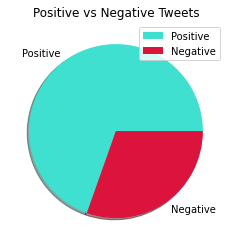

In [104]:
positive = round(np.count_nonzero(df['Sentiment'] == 'Positive') / len(df['Sentiment']) * 100, 2)
negative = round(np.count_nonzero(df['Sentiment'] == 'Negative') / len(df['Sentiment']) * 100, 2)

labels = ['Positive','Negative']
# Passing the values as a Numpy Array
values = np.array([positive, negative])
colors = ["turquoise", "crimson"]

fig, ax = plt.subplots()
ax.pie(values, labels = labels, shadow = True, colors = colors)
ax.legend()
ax.set_title("Positive vs Negative Tweets")
fig.show()

## Exporting Result to CSV

In [108]:
filename = 'Final.csv'
df.to_csv(filename, index=False)
print(filename + ' saved')

Final.csv saved
